1.) rank of A is C-1

In [0]:
import sys, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn import svm
import csv
import numpy as np
from sklearn.metrics import confusion_matrix

In [0]:
labelcol = 18

def drop_col(data, col):
    return data.drop(data.columns[[col]], axis = 1)


def contribution_map(eigenValues):
  #Summing the real and imaginary parts for the calculation of contribution percentage
  total_sum = np.sum(np.sum([np.real(eigenValues), np.imag(eigenValues)]))
  #print(total_sum)
  for i in eigenValues:
    contr_percent = round(((np.sum([np.real(i),np.imag(i)]) / total_sum) * 100),2)
    print("Eigen Values {} with contribution {}%".format(i, contr_percent))

# Function estimates the LDA parameters
def LDA(data, labels):
    
    # no. of classes
    # group data by label column
    data = pd.concat([data, labels.T], axis=1, join='inner')
    grouped = data.groupby(data.iloc[:, labelcol])
    classes = [c for c in grouped.groups.keys()]
    classwise = {} 
    for c in classes:
      classwise[c] = drop_col(grouped.get_group(c), labelcol)

    # calculate means for each class
    means = {}
    for c in classes:
        means[c] = np.array(classwise[c].mean(axis = 0))

    # calculate the overall mean of all the data
    overall_mean = np.array(drop_col(data, labelcol).mean(axis = 0))

    # calculate between class covariance matrix
    # S_B = \sigma{N_i (m_i - m) (m_i - m).T}
    S_B = np.zeros((data.shape[1] - 1, data.shape[1] - 1))
    for c in means.keys():
        S_B += np.multiply(len(classwise[c]), np.outer((means[c] - overall_mean), (means[c] - overall_mean)))

    # calculate within class covariance matrix
    # S_W = \sigma{S_i}
    S_W = 0
    for key, values in classwise.items():
      S_W = S_W + np.cov(values.T)

    # find eigenvalue, eigenvector pairs for inv(S_W).S_B
    mat = np.dot(np.linalg.pinv(S_W), S_B)
    eig_vals, eig_vecs = np.linalg.eig(mat)
    contribution_map(eig_vals)
    
    eiglist = [(eig_vals[i], eig_vecs[:, i]) for i in range(len(eig_vals))]

    # sort the eig_vals in decreasing order
    eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)

    # only first two eigenvalues are important as their contribution percentage are high
    # two eigenvectors
    u = np.array([eiglist[i][1] for i in range(2)])

    # two eigenvalues
    L = np.array([eiglist[i][0] for i in range(2)])

    projections = np.dot(drop_col(data, labelcol), u.T)

    return u, L, projections

In [0]:
def read_csv(file):
  with open(file, 'r') as f:
      data = pd.read_csv(f, delimiter=',',dtype="float64")
      labels = data.iloc[:, -1]
      featureData = data.iloc[:, 0:-1]
      return featureData, labels

In [4]:
train_data, train_labels = read_csv('train.csv')
coefficient, latent, new_data = LDA(train_data, train_labels)
new_data = np.real(new_data) + np.imag(new_data)

Eigen Values (461.69731516761505+0j) with contribution 53.5%
Eigen Values (375.5951877597206+0j) with contribution 43.52%
Eigen Values (25.77241232676358+0j) with contribution 2.99%
Eigen Values (3.2451160506876736e-11+0j) with contribution 0.0%
Eigen Values (-9.106749801399506e-12+0j) with contribution -0.0%
Eigen Values (-1.2847158678301603e-12+0j) with contribution -0.0%
Eigen Values (-9.777429556713247e-13+0j) with contribution -0.0%
Eigen Values (-1.886672609055532e-13+5.678274873490626e-13j) with contribution 0.0%
Eigen Values (-1.886672609055532e-13-5.678274873490626e-13j) with contribution -0.0%
Eigen Values (3.2712959258519677e-13+0j) with contribution 0.0%
Eigen Values (-1.4785353198101106e-13+0j) with contribution -0.0%
Eigen Values (1.2543497151960533e-13+7.96995729033113e-14j) with contribution 0.0%
Eigen Values (1.2543497151960533e-13-7.96995729033113e-14j) with contribution 0.0%
Eigen Values (3.941777179832194e-14+1.1563961462072108e-13j) with contribution 0.0%
Eigen Val

In [5]:
classifier = svm.SVC(gamma="scale", kernel="rbf")
classifier.fit(new_data, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
def plot_contour(data, labels, classifier, title):

  # make mesh grid
  x = np.arange(data[:,0].min(), data[:,0].max(), 0.02)
  y = np.arange(data[:,1].min(), data[:,1].max(), 0.02)
  X, Y = np.meshgrid(x, y)

  # plot contour and data scatter
  plt.figure()
  ax = plt.axes()
  Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
  Z = Z.reshape(X.shape)
  ax.contour(X, Y, Z, cmap='viridis' , alpha=0.9)
  ax.contourf(X, Y, Z, cmap='viridis' , alpha=0.9)
  scatter = ax.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', s=25, edgecolors='k', linewidth=1)
  ax.set_xlim(X.min(), X.max())
  ax.set_ylim(Y.min(), Y.max())
  ax.set_xlabel('LDA 1')
  ax.set_ylabel('LDA 2')
  ax.set_title(title)
  # produce a legend with the unique colors from the scatter
  ax.legend(handles=scatter.legend_elements(num=[1,2,3,4])[0], labels=['1: OPEL','2: SAAB','3: BUS','4: VAN'])
  plt.show()

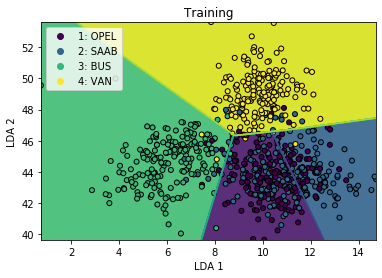

In [7]:
plot_contour(new_data, train_labels, classifier, "Training")

In [0]:
test_data, test_labels = read_csv('test.csv')
test_data_proj = np.dot(test_data, coefficient.T)
test_data_proj = np.real(test_data_proj) + np.imag(test_data_proj)

In [9]:
predicted_labels = classifier.predict(test_data_proj)
confusion_matrix(test_labels, predicted_labels)

array([[17,  5,  0,  0],
       [17,  9,  2,  0],
       [ 0,  0, 21,  0],
       [ 0,  1,  0, 21]])

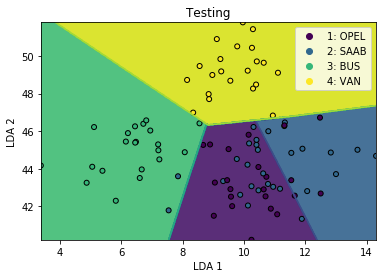

In [10]:
plot_contour(test_data_proj, test_labels, classifier, "Testing")

5.e) As we can see in the Figure 2 that class 2 is highly overlapping with class 1, i.e. most of the data points of class 2 lies in class 1, thus in the confusion matrix we find that in row 2 column 1, the value is high, meaning class 2 is wrongly classified as class 1. Hence, confusion matrix is in coherence with  result of Figure 2 